# 1. Preprocess - parse XML
Use BeautifulSoup to parse XML file. parseXML() is for part-1 only. It outputs with pandas dataframe "sentence id, sentence, E#A, sentiment". parseXML_p2() is for part-2 only. It reads review id instead of sentence id and does not read the text.

In [1]:
import re
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
def parseXML(path):
    with open(path) as xmldata:
        soup = BeautifulSoup(xmldata, "xml")
    # Create empty lists to store the extracted data
    sentence_ids = []
    texts = []
    categories = []
    polarities = []
    # Loop through the 'sentence' elements and extract the necessary information
    for sentence in soup.find_all('sentence'):
        opinions = sentence.find('Opinions')
        if opinions is not None:
            s_categories = []
            s_polarities = []
            for opinion in opinions.find_all('Opinion'):
                s_categories.append(opinion['category'])
                s_polarities.append(opinion['polarity'])
            categories.append(s_categories)
            polarities.append(s_polarities)
        else:
            continue
        sentence_ids.append(sentence['id'])
        texts.append(sentence.find('text').text)           

    # Create a pandas dataframe from the extracted data
    df = pd.DataFrame({'Sentence ID': sentence_ids,
                       'text': texts,
                       'label': categories,
                       'polarity': polarities})
#     print(f'{path.split("/")[-1]} has been parsed. The number of sentences with opinions is '
#           f"{len(soup.find_all('Opinions'))}({len(soup.find_all('sentence'))}).")
    
    return df

In [3]:
def parseXML_p2(path):
    with open(path) as xmldata:
        soup = BeautifulSoup(xmldata, "xml")
    # Create empty lists to store the extracted data
    review_rids = []
    categories = []
    polarities = []
    for review in soup.find_all('Review'):
        s_categories = []
        s_polarities = []
        for opinion in review.find_all('Opinion'):
            if opinion is not None:
                s_categories.append(opinion['category'])
                s_polarities.append(opinion['polarity'])
        categories.append(s_categories)
        polarities.append(s_polarities)
        review_rids.append(review['rid'])   
            

    # Create a pandas dataframe from the extracted data
    df = pd.DataFrame({'Review RID': review_rids,
                       'label': categories,
                       'polarity': polarities})
#     print(f'{path.split("/")[-1]} has been parsed. The number of reviews with opinions is '
#           f"{len(soup.find_all('Review'))}({len(df['label'])}).")
    
    return df

Get a overview of top n most frequent E\#A

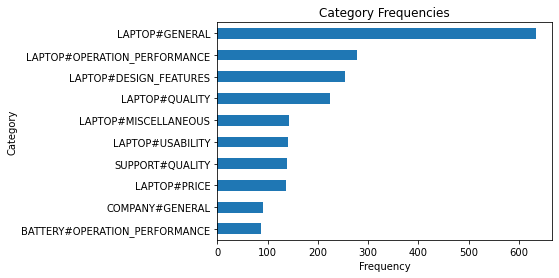

In [4]:
import matplotlib.pyplot as plt

# Split categories and create new rows
df_copy = parseXML("./data/Laptops_Train_p1.xml").copy()
split_categories = df_copy['label'].str.split(',')
df_copy = df_copy.assign(Category=split_categories).explode('label')

# Get the unique categories and their frequencies
category_counts = df_copy['label'].value_counts()
top_categories = category_counts.head(10)

# Plot the frequencies in descending order
top_categories.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Category Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Category')
plt.show()

# 2. Part 1 - Sentence-level Aspect Based Sentiment Analysis

+ Features - unigrams, tfidf, .etc 
+ Model - Logistic Regression Classifier
+ Evaluation - F-1 score for catagory extraction, accuracy for sentiment analysis

## 2.1 Features for Catagory Extraction

In [5]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report

In [6]:
def custom_tokenizer(text):
    # Tokenize the text using NLTK's word_tokenize function
    tokens = word_tokenize(text)
    # Remove punctuation
    tokens = [word for word in tokens if re.sub(r'[^\w\s]+', '', word).isalnum()]
    # Remove stopwords
    stop_words = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop_words]
    # Convert tokens to lowercase
    tokens = [token.lower() for token in tokens]   
    return tokens

def feature_unigram(df, df_t):    
    # Create a CountVectorizer instance to compute unigram counts
    count_vectorizer = CountVectorizer(tokenizer=custom_tokenizer,max_features=1000)
    # Fit and transform the sentences to obtain the unigram count features
    count_matrix = count_vectorizer.fit_transform(df['text'])
    count_matrix_t = count_vectorizer.transform(df_t['text'])
    # Convert the count matrix to a dataframe with appropriate column names
    count_df = pd.DataFrame(count_matrix.toarray(), columns=count_vectorizer.get_feature_names())
    count_df_t = pd.DataFrame(count_matrix_t.toarray(), columns=count_vectorizer.get_feature_names())
    return count_df, count_df_t

def feature_Tfidf(df, df_t):
    # Create a TfidfVectorizer instance to compute TF-IDF features
    tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
    # Fit and transform the sentences to obtain the TF-IDF features
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])
    tfidf_matrix_t = tfidf_vectorizer.transform(df_t['text'])
    # Convert the TF-IDF matrix to a dataframe with appropriate column names
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names())
    tfidf_df_t = pd.DataFrame(tfidf_matrix_t.toarray(), columns=tfidf_vectorizer.get_feature_names())
    return tfidf_df, tfidf_df_t

def catagory_extraction_feature_selection(train, test, features='unigram'):
    """
    parameter:
        train,test: df
        dataset being trained and tested on
        features: String
        which consists of customised features "unigram,Tfidf,..." splitted by "," 
    
    returns:
        x_train, x_test, y_train, y_test = DataFrame
        only includes the data needed for training and test.
    """
    # Customised
    # Concatenate the original dataframe with the features selected
    # Ignore upper/lower case, leading or trailing whitespaces
    features_set = {'tfidf','unigram'}
    customised_features_set = set(feature.strip().lower() for feature in features.split(","))
    if not customised_features_set.issubset(features_set):
        raise ValueError("Please input with right features.")

    features_list = []
    # Appending tuples at first
    if 'tfidf' in customised_features_set:
        features_list.append(feature_unigram(train, test))
    if 'unigram' in customised_features_set:
        features_list.append(feature_Tfidf(train, test))
    # Unpacking
    x_train_features = []
    x_test_features = []
    for x_train_feature, x_test_feature in features_list:
        x_train_features.append(x_train_feature)
        x_test_features.append(x_test_feature)
    # convert to DataFrame
    x_train = pd.concat(x_train_features, axis=1)
    x_test = pd.concat(x_test_features, axis=1)
        
    return x_train, x_test

## 2.2 Logistic Regression Classifier for Catagory Extraction 

+ multi-label classification

In [7]:
def catagory_extraction_LogisticRegressionClf(threshold=0.2,features='unigram'):
    """
        Train the classifer using selected data, make predictions on training data and 
        Generate classification report for test data
        
        parameter:
            threshold: float, range from 0 to 1
            each sentence can be assigned to multiple classes simultaneously with 
            probability larger than threshold
            
            features: String
            which consists of customised features "unigram,Tfidf,..." splitted by "," 
            and will be used by the training of classifier
    """
    #data preprocessing
    Laptops_Train_p1 = parseXML("./data/Laptops_Train_p1.xml")
    Laptops_Test_p1_gold = parseXML("./data/Laptops_Test_p1_gold.xml")

    x_train, x_test = catagory_extraction_feature_selection(Laptops_Train_p1, Laptops_Test_p1_gold, features=features)
    
    # Convert the labels into binary arrays
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(Laptops_Train_p1['label'])
    y_test = mlb.transform(Laptops_Test_p1_gold['label'])
    # Create a dataframe for the binary label arrays
    y_train = pd.DataFrame(y, columns=mlb.classes_)
    y_test = pd.DataFrame(y_test, columns=mlb.classes_)
    
    # Create an instance of LogisticRegression
    clf = LogisticRegression(max_iter=1000)
    y_pred = np.zeros(y_test.shape)
    # Iterate through each label and train a separate binary classifier
    for i in range(y_train.shape[1]):

        # Fit the model on the training data for the current label
        clf.fit(x_train, y_train.iloc[:, i])
        # Predict the probabilities of the current label for the testing data
        y_pred_prob = clf.predict_proba(x_test)[:, 1] # Use probabilities of positive class (1)

        # Set the threshold for category assignment
        t = threshold

        # Generate predicted labels based on threshold
        y_pred_labels = np.where(y_pred_prob >= t, 1, 0)

        # Add predicted labels to the corresponding column in the binary label array
        y_pred[:, i] = y_pred_labels.tolist()


    # Generate classification report
    report = classification_report(y_test, y_pred, zero_division=1)
    print("Classification Report:\n", report)
        
    test_predicted_labels = pd.DataFrame({'label': mlb.inverse_transform(y_pred)})    
    return pd.concat([Laptops_Test_p1_gold['Sentence ID'], test_predicted_labels], axis=1)

In [8]:
test_predicted_labels = catagory_extraction_LogisticRegressionClf()

/home/xinpeng/APP/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['BATTERY#DESIGN_FEATURES', 'CPU#GENERAL', 'HARD_DISC#GENERAL', 'HARD_DISC#OPERATION_PERFORMANCE', 'OPTICAL_DRIVES#DESIGN_FEATURES', 'OPTICAL_DRIVES#GENERAL', 'POWER_SUPPLY#GENERAL'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         0
           1       0.74      0.74      0.74        19
           2       1.00      0.00      0.00         5
           3       0.57      0.11      0.18        38
           4       1.00      0.00      0.00         3
           5       1.00      0.00      0.00         1
           6       1.00      0.00      0.00         2
           7       1.00      1.00      1.00         0
           8       1.00      0.00      0.00        13
           9       0.00      0.00      0.00         4
          10       1.00      0.00      0.00         8
          11       0.80      0.20      0.32        20
          12       1.00      0.00      0.00         5
          13       1.00      1.00      1.00         0
          14       1.00      0.00      0.00         2
          15       1.00      1.00      1.00         0
          16       1.00      0.00      0.00         2
   

## 2.3 Features for Sentiment Analysis

In [9]:
def dataframe_expansion(df):
    original_labels = df['label'].tolist()
    original_polarities = df['polarity'].tolist()
    
    # ==advanced indexing==
    reps = [len(val) for val in df['label']]
    df = df.loc[np.repeat(df.index.values, reps)]
    
    df['label'] = [item for sublist in original_labels for item in sublist]
    df['polarity'] = [item for sublist in original_polarities for item in sublist]
    
    return df

def dataframe_undoexpansion(y_pred, test):
    y_pred = pd.DataFrame({'polarity': y_pred})
    y_pred = inverse_numerical_rep(y_pred['polarity'])
    y_pred = y_pred.tolist()
    y_aligned = []
    for index, row in test.iterrows():
        sublist = []
        for i in range(len(row['polarity'])):
            sublist.append(y_pred.pop(0))
        y_aligned.append(sublist)
    test_pred = test.copy()
    test_pred['polarity'] = y_aligned
    return test_pred

def onehotting(x_train, x_test):
    # Convert 'label' column in x_train and x_test to one-hot encoding
    x_train_onehot = pd.get_dummies(x_train['label'], prefix='class')
    x_test_onehot = pd.get_dummies(x_test['label'], prefix='class')

    # Get the columns that are missing in x_test_onehot
    missing_cols = set(x_train_onehot.columns) - set(x_test_onehot.columns)
    for col in missing_cols:
        x_test_onehot[col] = 0

    # Reorder the columns in x_test_onehot to match the column names in x_train_onehot
    x_test_onehot = x_test_onehot[x_train_onehot.columns]
    
    # Concatenate x_train and x_test with one-hot encoded columns
    x_train = pd.concat([x_train, x_train_onehot], axis=1)
    x_test = pd.concat([x_test, x_test_onehot], axis=1)

    return x_train, x_test

def numerical_rep(df):
    df = df.copy()
    y_dict = {'positive': 1, 'negative': -1, 'neutral': 0}
    y = df.map(y_dict)
    return y

def inverse_numerical_rep(df):
    df = df.copy()
    y_dict = {'positive': 1, 'negative': -1, 'neutral': 0}
    reverse_y_dict = {v: k for k, v in y_dict.items()} # Reverse the keys and values in y_dict
    y = df.map(reverse_y_dict)
    return y

In [10]:
def sentiment_analysis_feature_selection(train, test, features='unigram'):
    """
    parameter:
        train,test: df
        dataset being trained and tested on
        features: String
        which consists of customised features "unigram,Tfidf,..." splitted by "," 
    
    returns:
        x_train, x_test, y_train, y_test = DataFrame
        only includes the data needed for training and test.
    """
    # Customised
    # Concatenate the original dataframe with the features selected
    # Ignore upper/lower case, leading or trailing whitespaces
    features_set = {'tfidf','unigram'}
    customised_features_set = set(feature.strip().lower() for feature in features.split(","))
    if not customised_features_set.issubset(features_set):
        raise ValueError("Please input with right features.")

    features_list = []
    # Appending tuples at first
    if 'tfidf' in customised_features_set:
        features_list.append(feature_unigram(train, test))
    if 'unigram' in customised_features_set:
        features_list.append(feature_Tfidf(train, test))
    # Unpacking
    x_train_features = []
    x_test_features = []
    for x_train_feature, x_test_feature in features_list:
        x_train_features.append(x_train_feature)
        x_test_features.append(x_test_feature)
    # convert to DataFrame
    x_train = pd.concat(x_train_features, axis=1)
    x_test = pd.concat(x_test_features, axis=1)
    
    # Default
    # numerical representation of polarity
    xy_train = dataframe_expansion(pd.concat([train, x_train], axis=1))
    xy_test = dataframe_expansion(pd.concat([test, x_test], axis=1))
    y_train = numerical_rep(xy_train['polarity'])
    y_test = numerical_rep(xy_test['polarity'])
    # label one-hotting
    x_train, x_test = onehotting(xy_train, xy_test)
    # Drop the original 'label' column from x_train and x_test
    x_train.drop(train.columns.values.tolist(), axis=1, inplace=True)
    x_test.drop(test.columns.values.tolist(), axis=1, inplace=True)
    
    return x_train, x_test, y_train, y_test

## 2.4 Logistic Regression Classifer for Sentiment Analysis

In [11]:
def sentiment_anaylysis_LogisticRegressionClf(features='unigram'):
    """
        Train the classifer using selected data, make predictions on training data and 
        Generate classification report for test data
        
        parameter:        
            features: String
            which consists of customised features "unigram,Tfidf,..." splitted by "," 
            and will be used by the training of classifier
    """
    Laptops_Train_p1 = parseXML("./data/Laptops_Train_p1.xml")
    Laptops_Test_p1_gold = parseXML("./data/Laptops_Test_p1_gold.xml")

    # Feature selection
    x_train, x_test, y_train, y_test = sentiment_analysis_feature_selection(Laptops_Train_p1, Laptops_Test_p1_gold, features=features)
        
    # Create an instance of LogisticRegression
    clf = LogisticRegression(max_iter=1000)
    clf.fit(x_train, y_train)

    # Make predictions on training data
    y_pred = clf.predict(x_test)

    # Generate classification report for training data
    classification_report_train = classification_report(y_test, y_pred)
    print("Classification Report (Training Data):\n", classification_report_train)
    
    # Data format alignment
    test_aligned = dataframe_undoexpansion(y_pred, Laptops_Test_p1_gold)
    
    return test_aligned

In [12]:
test_aligned = sentiment_anaylysis_LogisticRegressionClf(features='unigram')

Classification Report (Training Data):
               precision    recall  f1-score   support

          -1       0.66      0.68      0.67       274
           0       0.33      0.07      0.11        46
           1       0.79      0.84      0.81       481

    accuracy                           0.74       801
   macro avg       0.60      0.53      0.53       801
weighted avg       0.72      0.74      0.72       801



# 3. Part 2 - Text-level Aspect Based Sentiment Analysis

Traverse the predicted sentence-level tuples of the same category and counts the respective polarity labels (positive, negative or neutral). Finally, the polarity label with the highest frequency is assigned to the text-level category. If there are not any sentence-level tuples of the same category the polarity label is determined based on all tuples regardless of the category.

In [13]:
from collections import Counter

In [14]:
def group_to_text_level(df):
    
    df = df.copy()    
    # Split the 'Sentence ID' column by ':' and only keep the first part
    df['Sentence ID'] = df['Sentence ID'].apply(lambda x: x.split(':')[0])
    # Group the rows by 'Sentence ID' and combine the 'label' and 'polarity' values into a list
    grouped_df = df.groupby('Sentence ID', sort=False).agg({'label': lambda x: [item for sublist in x for item in sublist]})
    # Reset the index to turn 'Sentence ID' back into a regular column
    grouped_df = grouped_df.reset_index()
    grouped_df = grouped_df.rename(columns={'Sentence ID': 'Review RID'})
    
    return grouped_df

def group_to_text_level2(df):
    
    df = df.copy()    
    # Split the 'Sentence ID' column by ':' and only keep the first part
    df['Sentence ID'] = df['Sentence ID'].apply(lambda x: x.split(':')[0])
    # Group the rows by 'Sentence ID' and combine the 'label' and 'polarity' values into a list
    grouped_df = df.groupby('Sentence ID',sort=False).agg({'label': lambda x: sum(x, []), 'polarity': lambda x: sum(x, [])})
    # Reset the index to turn 'Sentence ID' back into a regular column
    grouped_df = grouped_df.reset_index()
    grouped_df = grouped_df.rename(columns={'Sentence ID': 'Review RID'})
    
    return grouped_df

def get_most_frequent_polarity_dist(row):
    dict1 = {}
    for key, value in zip(row['label'], row['polarity']):
        if key in dict1:
            dict1[key].append(value)
        else:
            dict1[key] = [value]
    most_frequent_values = {}
    for key, value_list in dict1.items():
        most_frequent_values[key] = max(set(value_list), key=value_list.count)

    return most_frequent_values
    
def get_polarities_frequency_dict(row):
    frequency_distribution = Counter(row['polarity'])
    most_frequent_key = frequency_distribution.most_common(1)[0][0]
    return most_frequent_key


In [15]:
def caculate_accuracy(df):
    # Initialize variables for the total number of predictions and correct predictions
    total_predictions = 0
    total_correct_predictions = 0

    # Iterate over each row in the dataframe
    for i, row in df.iterrows():
        # Get the actual and predicted polarity values as lists of strings
        actual_polarity = row['polarity']
        predicted_polarity = row['pred_polarity']

        # Calculate the number of correctly predicted polarities
        num_correct = sum(1 for x, y in zip(actual_polarity, predicted_polarity) if x == y)

        # Update the total number of predictions and correct predictions
        total_predictions += len(actual_polarity)
        total_correct_predictions += num_correct

    # Calculate the overall accuracy as a fraction
    overall_accuracy = total_correct_predictions / total_predictions
    
    return overall_accuracy

In [16]:
def text_level_ABSA(test_pred, test_predicted_labels):
    """
        Determine the polarity and label of test-level based on sentence-level results.
        The polarity with the highest frequency is assigned to the text-level category.
        If there are not any sentence-level tuples of the same category the polarity 
        label is determined based on all tuples regardless of the category.
        
        parameter:        
            test_pred: df
            sentence-level sentiment results
    """
    test_p2 = parseXML_p2("./data/Laptops_Test_p2_gold.xml")
    
    mlb = MultiLabelBinarizer()
    test_predicted_labels = group_to_text_level(test_predicted_labels)
    y = mlb.fit_transform(test_p2['label'])
    y_pred = mlb.transform(test_predicted_labels['label'])
    # Create a dataframe for the binary label arrays
    y = pd.DataFrame(y, columns=mlb.classes_)
    y_pred = pd.DataFrame(y_pred, columns=mlb.classes_)
    # Generate classification report for training data
    classification_report_train = classification_report(y, y_pred, zero_division=1)
    print("Classification Report (Training Data):\n", classification_report_train)

    df = group_to_text_level2(test_pred)
    test_p2['most_frequent_polarity_dist'] = df.apply(get_most_frequent_polarity_dist, axis=1)
    test_p2['polarity_distribution'] = df.apply(get_polarities_frequency_dict, axis=1)
    
    test_p2 = test_p2.reset_index()
    text_p2_pred = []
    for index, row in test_p2.iterrows():
        sublist = []
        for label in row['label']:
            if label in row['most_frequent_polarity_dist']:
                sublist.append(row['most_frequent_polarity_dist'][label])
            else:
                sublist.append(row['polarity_distribution'])
        text_p2_pred.append(sublist)
    test_p2['pred_polarity'] = text_p2_pred
    
    print("Overall accuracy of sentiment polarity of text-level E#A: {:.2%}".format(caculate_accuracy(test_p2)))
    

In [17]:
text_level_ABSA(test_aligned,test_predicted_labels)

Classification Report (Training Data):
               precision    recall  f1-score   support

           0       1.00      0.00      0.00         1
           1       0.86      0.86      0.86        14
           2       1.00      0.00      0.00         3
           3       0.71      0.21      0.32        24
           4       1.00      0.00      0.00         3
           5       1.00      0.00      0.00         1
           6       1.00      0.00      0.00         1
           7       1.00      0.00      0.00         3
           8       1.00      0.00      0.00        12
           9       0.00      0.00      0.00         4
          10       1.00      0.00      0.00         6
          11       0.80      0.19      0.31        21
          12       1.00      0.00      0.00         5
          13       1.00      0.00      0.00         2
          14       1.00      0.00      0.00         2
          15       1.00      0.00      0.00         1
          16       1.00      0.00      0.

# 4. Summary

**Evaluation**:
+ part-1 sentence-level ABSA
 + catagory extraction - micro F1-score: 0.38
 + sentiment analysis - accuracy: 0.74
+ part-2 text-level ABSA
 + catagory extraction - micro F1-score:0.55
 + sentiment analysis - accuracy: 0.74

**Future things to try**:
+ Instead of using tf-idf or unigram features, apply word2vec/GloVe/FastText/context2vec  embedding techniques trained on external dataset to capture the syntactic and semantic relationships between words in a sentence.
+ Instead of using logistic regression for classification, apply Pre-trained Language Models(PLM) such as BERT or OpenGPT, add specific layers on top of the PLM to generate the final output for the classification task, and then train it alone with the fixed PLM. 